In [598]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
import numpy as np
import scipy.stats as stats
import os
import matplotlib.colors as mcolors
from scipy.stats import ttest_ind
from sklearn.cluster import AgglomerativeClustering, KMeans
import seaborn as sns
from scipy.cluster import hierarchy
from statsmodels.stats.multitest import multipletests

In [599]:
raw_file = "/lab/wengpj01/assay/data_BitterAssay_ver231125-1.csv"

In [600]:
os.chdir("/lab/wengpj01/assay/20231127")

In [601]:
raw = pd.read_csv(raw_file, index_col=0, usecols=lambda column: column != 'Unnamed: 0')

In [602]:
#Convert gene names

converter_file = "/lab/wengpj01/assay/Converter_file.csv"
converter = pd.read_csv(converter_file)

# Merge the dataframes based on the matching condition
raw = raw.merge(converter, left_on='gene', right_on='Aki', how='left')

# Rename the "Paper" column to "new_gene"
raw = raw.rename(columns={'gene': 'old_gene'})
raw = raw.rename(columns={'Paper': 'gene'})
raw = raw.drop(columns=['Aki', 'Seq'])

In [663]:
##Now with BH MHC applied across dataset

def create_colored_max_p_values_byall(df, comps=None, gene_order=None, output_file="colored_map_max_values_whgreen_withBH_byall.pdf"):
    if comps is None:
        unique_compounds = ['Buffer', 'AflatoxinB1', 'Batrachotoxin', 'Cinobufagin', 'Heliotrine', 'Marinobufagenin', 'Swainsonine','Amarogentin', 'Arbutin', 'Aristolochic_acid', 'a-thujone','Camphor', 'Chloramphenicol',
                    'Chloroquine', 'Colchicine', 'Coumarin', 'Denatonium_benzoate', 'Diphenylthiourea', 'Genistein', 
                    'Helicin', 'PROP', 'PTC', 'Papaverine', 'Picrotoxin', 'Quinine', 'Salicin', 'Strychnine',
                    'Xanthotoxin', 'Yohimbine' ]
        unique_compounds2 = ['AflatoxinB1', 'Batrachotoxin', 'Cinobufagin', 'Heliotrine', 'Marinobufagenin', 'Swainsonine','Amarogentin', 'Arbutin', 'Aristolochic_acid', 'a-thujone','Camphor', 'Chloramphenicol',
                    'Chloroquine', 'Colchicine', 'Coumarin', 'Denatonium_benzoate', 'Diphenylthiourea', 'Genistein', 
                    'Helicin', 'PROP', 'PTC', 'Papaverine', 'Picrotoxin', 'Quinine', 'Salicin', 'Strychnine',
                    'Xanthotoxin', 'Yohimbine' ]
    else:
        unique_compounds = comps
        
    if gene_order is None:
        sorted_genes = ["axolotl_42", "cane_56", "cane_54", "clawed_23", "clawed_31", "clawed_20", "bullfrog_61", "bullfrog_51", "clawed_2", 
                       "cane_17", "cane_58", "bullfrog_12", "bullfrog_17", "clawed_18", "dart_15", "axolotl_10", "dart_18", "axolotl_54"]
    else:
        sorted_genes = gene_order
        
    counter = 0

    blue_p_value = 0.001
    white_p_value = 0.05

    blue_color = '#0000FF'  
    red_color = '#BF0A30'
    white_color = '#FFFFFF'
    gray_color = '#808080'
    purple_color = '#AC71F3'
    green_color = '#097969'

    # Create a custom colormap using specified colors
    custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', [white_color, green_color], N=256)


    color_matrix = np.zeros((len(sorted_genes), len(unique_compounds2)), dtype=float)

    adjusted_p_values = []
    is_significant = []
    p_values = []
    for i, gene in enumerate(sorted_genes):
        df_gene = df[df['gene'] == gene]
        buffer_data = df_gene[df_gene['compound'] == 'Buffer']['AUC']
        buffer_mean = buffer_data.mean()

        

        for j, chem in enumerate(unique_compounds2):
            if chem == 'Buffer':
                continue

            chem_data = df_gene[df_gene['compound'] == chem]['AUC']
            _, p_value = ttest_ind(chem_data, buffer_data, equal_var=False)
            p_values.append(p_value if not np.isnan(p_value) else 1)  # Replace NaN with 1

    reject, adjusted_p_vals, _, _ = multipletests(p_values, method='fdr_bh')

    for adj_pval in adjusted_p_vals:
        adjusted_p_values.append(adj_pval)
    
    for i, gene in enumerate(sorted_genes):
        df_gene = df[df['gene'] == gene]
        buffer_data = df_gene[df_gene['compound'] == 'Buffer']['AUC']
        buffer_mean = buffer_data.mean()
        
        chem_mean_max=0
        # Iterate through each unique compound (excluding "Buffer")
        for j, chem in enumerate(unique_compounds):
            if chem == 'Buffer':
                continue

            # Filter chemical data
            chem_data = df_gene[df_gene['compound'] == chem]['AUC']
            chem_mean = chem_data.mean()
            _, p_value = ttest_ind(chem_data, buffer_data)
            if p_value < white_p_value:
                if chem_mean > chem_mean_max:
                        chem_mean_max=chem_mean
        
        
        for j, chem in enumerate(unique_compounds):
            if chem == 'Buffer':
                continue

            # Filter chemical data
            chem_data = df_gene[df_gene['compound'] == chem]['AUC']
            chem_mean = chem_data.mean()
#             adjusted_p_value = adjusted_p_values[(i*(len(unique_compounds)-1))+j-1]

        # Update color_matrix based on adjusted p-values and significance flags
        for j, chem in enumerate(unique_compounds2): 
            chem_data = df_gene[df_gene['compound'] == chem]['AUC']
            chem_mean = chem_data.mean()
            adjusted_p_value = adjusted_p_values[(i*(len(unique_compounds2)))+j]
            p_value = p_values[(i*(len(unique_compounds2)))+j]
#             print(p_values[(i*(len(unique_compounds2)))+j])
#             print(adjusted_p_values[(i*(len(unique_compounds2)))+j])
            #print(counter)
            if not chem_data.empty:
                
                # Check if p-value is significant (p <= white_p_value)
                if adjusted_p_value >= white_p_value:
                    color_matrix[i, j] = np.nan  # Set as NaN for non-significant results
                elif chem_mean <= buffer_mean:
                    color_matrix[i, j] = np.nan  # Set as NaN for non-significant results
                else:
                    # Calculate (mean_chem - mean_buffer) / (mean_max - mean_chem)
#                     print(chem)
#                     print(gene)
                    color_value = (chem_mean - buffer_mean) / (chem_mean_max- buffer_mean)
                    color_matrix[i, j] = color_value
#                     print(color_value)
                    if color_value ==1:
                        counter +=1
                        #print("yes")
#                 if chem=="Batrachotoxin":
#                         print(gene)
#                         print(chem_mean)
#                         print(p_value)
#                         print(adjusted_p_value)
            else:
                color_matrix[i, j] = np.nan
#     print((p_values))
                
    fig, ax = plt.subplots(figsize=(16, 6))
    cax = ax.matshow(color_matrix[:, :], cmap=custom_cmap)

    ax.set_xticks(range(0, len(unique_compounds) - 1))
    ax.set_xticklabels(unique_compounds[1:], rotation=45, ha="left")
    ax.set_yticks(np.arange(len(sorted_genes)))
    ax.set_yticklabels(sorted_genes)

    plt.savefig(output_file, format='pdf', bbox_inches='tight')

    cbar = plt.colorbar(cax, ticks=[0, 1])
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(['Buffer or less', '100% of receptor max'])

    plt.savefig(output_file, format='pdf', bbox_inches='tight')



In [670]:
##Now with BH MHC applied across each gene alone

def create_colored_max_p_values_byrow(df, comps=None, gene_order=None, output_file="colored_map_max_values_whgreen_withBH_byrow.pdf"):
    if comps is None:
        unique_compounds = ['Buffer', 'AflatoxinB1', 'Batrachotoxin', 'Cinobufagin', 'Heliotrine', 'Marinobufagenin', 'Swainsonine','Amarogentin', 'Arbutin', 'Aristolochic_acid', 'a-thujone','Camphor', 'Chloramphenicol',
                    'Chloroquine', 'Colchicine', 'Coumarin', 'Denatonium_benzoate', 'Diphenylthiourea', 'Genistein', 
                    'Helicin', 'PROP', 'PTC', 'Papaverine', 'Picrotoxin', 'Quinine', 'Salicin', 'Strychnine',
                    'Xanthotoxin', 'Yohimbine' ]
        unique_compounds2 = ['AflatoxinB1', 'Batrachotoxin', 'Cinobufagin', 'Heliotrine', 'Marinobufagenin', 'Swainsonine','Amarogentin', 'Arbutin', 'Aristolochic_acid', 'a-thujone','Camphor', 'Chloramphenicol',
                    'Chloroquine', 'Colchicine', 'Coumarin', 'Denatonium_benzoate', 'Diphenylthiourea', 'Genistein', 
                    'Helicin', 'PROP', 'PTC', 'Papaverine', 'Picrotoxin', 'Quinine', 'Salicin', 'Strychnine',
                    'Xanthotoxin', 'Yohimbine' ]
    else:
        unique_compounds = comps
        
    if gene_order is None:
        sorted_genes = ["axolotl_42", "cane_56", "cane_54", "clawed_23", "clawed_31", "clawed_20", "bullfrog_61", "bullfrog_51", "clawed_2", 
                       "cane_17", "cane_58", "bullfrog_12", "bullfrog_17", "clawed_18", "dart_15", "axolotl_10", "dart_18", "axolotl_54"]
    else:
        sorted_genes = gene_order
        
    counter = 0

    blue_p_value = 0.001
    white_p_value = 0.05

    blue_color = '#0000FF'  
    red_color = '#BF0A30'
    white_color = '#FFFFFF'
    gray_color = '#808080'
    purple_color = '#AC71F3'
    green_color = '#097969'

    # Create a custom colormap using specified colors
    custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', [white_color, green_color], N=256)


    color_matrix = np.zeros((len(sorted_genes), len(unique_compounds2)), dtype=float)

    adjusted_p_values = []
    is_significant = []
    for i, gene in enumerate(sorted_genes):
        p_values = []
        df_gene = df[df['gene'] == gene]
        buffer_data = df_gene[df_gene['compound'] == 'Buffer']['AUC']
        buffer_mean = buffer_data.mean()

        

        for j, chem in enumerate(unique_compounds2):
            if chem == 'Buffer':
                continue

            chem_data = df_gene[df_gene['compound'] == chem]['AUC']
            _, p_value = ttest_ind(chem_data, buffer_data, equal_var=False)
            p_values.append(p_value if not np.isnan(p_value) else 1)  # Replace NaN with 1

        reject, adjusted_p_vals, _, _ = multipletests(p_values, method='fdr_bh')
        for adj_pval in adjusted_p_vals:
            adjusted_p_values.append(adj_pval)
    for i, gene in enumerate(sorted_genes):
        df_gene = df[df['gene'] == gene]
        buffer_data = df_gene[df_gene['compound'] == 'Buffer']['AUC']
        buffer_mean = buffer_data.mean()
        
        chem_mean_max=0
        # Iterate through each unique compound (excluding "Buffer")
        for j, chem in enumerate(unique_compounds):
            if chem == 'Buffer':
                continue

            # Filter chemical data
            chem_data = df_gene[df_gene['compound'] == chem]['AUC']
            chem_mean = chem_data.mean()
            _, p_value = ttest_ind(chem_data, buffer_data)
            if p_value < white_p_value:
                if chem_mean > chem_mean_max:
                        chem_mean_max=chem_mean
        
        
        for j, chem in enumerate(unique_compounds):
            if chem == 'Buffer':
                continue

            # Filter chemical data
            chem_data = df_gene[df_gene['compound'] == chem]['AUC']
            chem_mean = chem_data.mean()
#             adjusted_p_value = adjusted_p_values[(i*(len(unique_compounds)-1))+j-1]

        # Update color_matrix based on adjusted p-values and significance flags
        for j, chem in enumerate(unique_compounds2): 
            chem_data = df_gene[df_gene['compound'] == chem]['AUC']
            chem_mean = chem_data.mean()
            adjusted_p_value = adjusted_p_values[(i*(len(unique_compounds2)))+j]
#             print(p_values[(i*(len(unique_compounds2)))+j])
#             print(adjusted_p_values[(i*(len(unique_compounds2)))+j])
            #print(counter)
            if not chem_data.empty:
                
                # Check if p-value is significant (p <= white_p_value)
                if adjusted_p_value >= white_p_value:
                    color_matrix[i, j] = np.nan  # Set as NaN for non-significant results
                elif chem_mean <= buffer_mean:
                    color_matrix[i, j] = np.nan  # Set as NaN for non-significant results
                else:
                    # Calculate (mean_chem - mean_buffer) / (mean_max - mean_chem)
#                     print(chem)
#                     print(gene)
                    color_value = (chem_mean - buffer_mean) / (chem_mean_max- buffer_mean)
                    color_matrix[i, j] = color_value
#                     print(color_value)
                    if color_value ==1:
                        counter +=1
                        #print("yes")
#                 if chem=="Batrachotoxin":
#                         print(gene)
#                         print(chem_mean)
#                         print(p_value)
#                         print(adjusted_p_value)
            else:
                color_matrix[i, j] = np.nan
#     print((p_values))
                
    fig, ax = plt.subplots(figsize=(16, 6))
    cax = ax.matshow(color_matrix[:, :], cmap=custom_cmap)

    ax.set_xticks(range(0, len(unique_compounds) - 1))
    ax.set_xticklabels(unique_compounds[1:], rotation=45, ha="left")
    ax.set_yticks(np.arange(len(sorted_genes)))
    ax.set_yticklabels(sorted_genes)

    plt.savefig(output_file, format='pdf', bbox_inches='tight')

    cbar = plt.colorbar(cax, ticks=[0, 1])
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(['Buffer or less', '100% of receptor max'])

    plt.savefig(output_file, format='pdf', bbox_inches='tight')



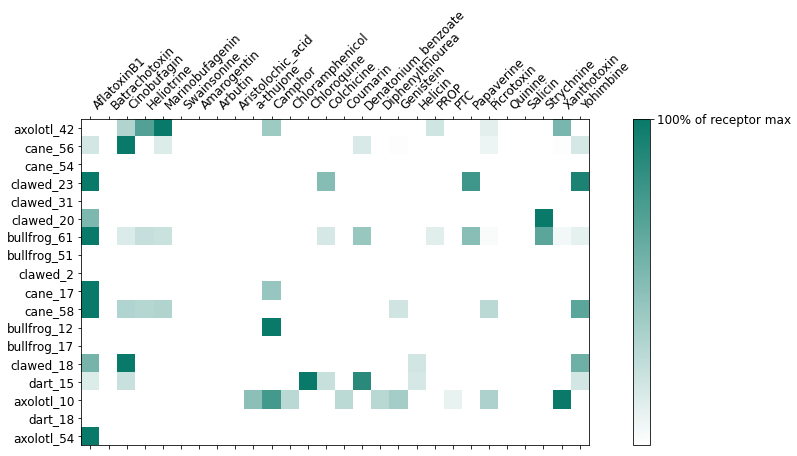

In [671]:
create_colored_max_p_values_byrow(raw)
unique_compounds2 = ['AflatoxinB1', 'Batrachotoxin', 'Cinobufagin', 'Heliotrine', 'Marinobufagenin', 'Swainsonine','Amarogentin', 'Arbutin', 'Aristlochic_acid', 'a-thujone','Camphor', 'Chloramphenicol',
                    'Chloroquine', 'Colchicine', 'Coumarin', 'Denatonium_benzoate', 'Diphenylthiourea', 'Genistein', 
                    'Helicin', 'PROP', 'PTC', 'Papaverine', 'Picrotoxin', 'Quinine', 'Salicin', 'Strychnine',
                    'Xanthotoxin', 'Yohimbine' ]

In [285]:
def plot_all_chems(df, gene, comps = None,output_file="boxplot.pdf"):
    df2 = df[df["gene"]==gene]
    
    if comps == None:
        unique_compounds = ['Buffer','Amarogentin', 'Arbutin', 'Aristlochic_acid', 'Camphor', 'Chloramphenicol',
                        'Chloroquine', 'Colchicine', 'Coumarin', 'Denatonium_benzoate', 'Diphenylthiourea', 'Genistein', 
                        'Helicin', 'PROP', 'PTC', 'Papaverine', 'Picrotoxin', 'Quinine', 'Salicin', 'Strychnine',
                        'Xanthotoxin', 'Yohimbine', 'a-thujone','AflatoxinB1','Batrachotoxin0001', 'Cinobufagin01','Heliotrine05', 'Marinobufagenin','Swainsonine']
    else:
        unique_compounds = comps

    # Iterate through rows in the DataFrame
    list_chems = []
    for chem in unique_compounds:
        df3 = df2[df2["compound"]==chem]
        list_chems.append(df3["AUC"])
    
    if len(unique_compounds) > 10:
        fig = plt.figure(figsize = (8,3))
    elif len(unique_compounds) > 3:
        fig = plt.figure(figsize = (5,3))
    else:
        fig = plt.figure(figsize = (2,3))
    ax1 = fig.add_subplot(111)
    
#     # Define a dictionary with color options
#     box_colors = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray', fliers='Red')

    # Create a boxplot with custom colors
    #bp = ax1.boxplot(list_chems, patch_artist=True, boxprops=dict(facecolor='LightGreen', color='DarkGreen'), **box_colors)
    bp = ax1.boxplot(list_chems,
           patch_artist = True,
           boxprops = dict(facecolor = "lightblue"))
    
    bp = ax1.boxplot(list_chems)
    # Set the x-axis tick labels
    ax1.set_xticks(range(1, len(unique_compounds) + 1))
    ax1.set_xticklabels(unique_compounds, rotation=45, ha="right")
    
    # Add title and axis labels
    ax1.set_title(f'Bitter Assay for {gene}')
    ax1.set_xlabel('Compounds')
    ax1.set_ylabel('AUC Values')
    
    # Save the boxplot as a PDF file
    plt.savefig(output_file, format='pdf', bbox_inches='tight')
    
#     print(unique_compounds)

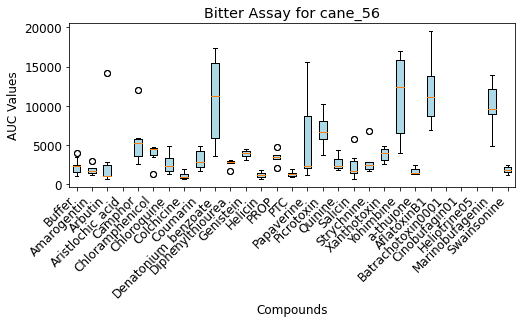

In [585]:
plot_all_chems(raw, "cane_56",output_file="scratch.pdf")

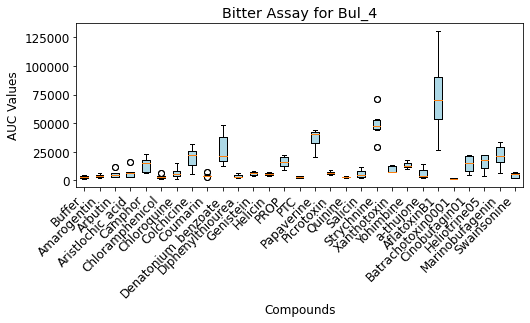

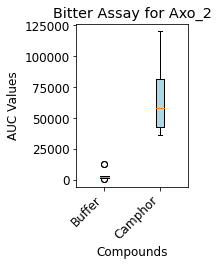

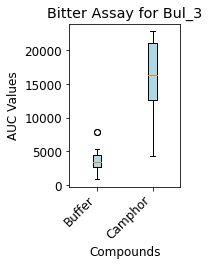

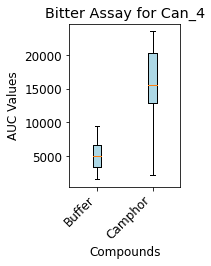

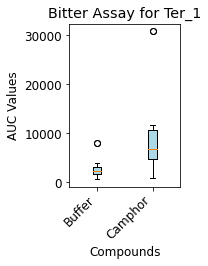

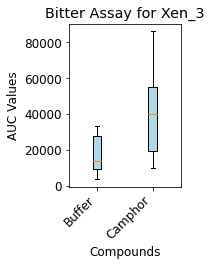

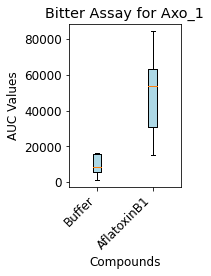

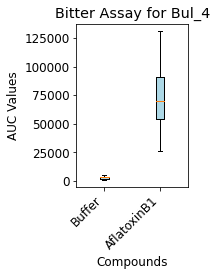

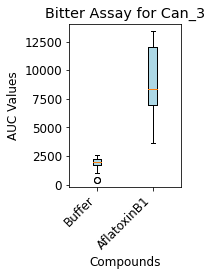

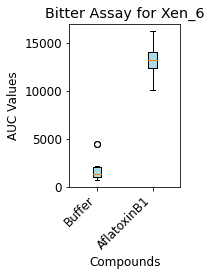

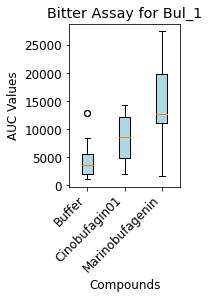

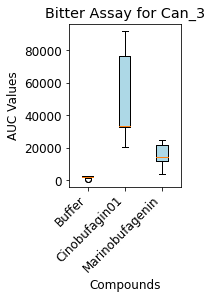

In [44]:
#plot_all_chems(df, gene, comps = None,output_file="boxplot.png")
plot_all_chems(raw, "Bul_4", comps = None,output_file="Bull_all.pdf")
plot_all_chems(raw, "Axo_2", comps = ["Buffer", "Camphor"],output_file="Axo_2_camphor.pdf")
plot_all_chems(raw, "Bul_3", comps = ["Buffer", "Camphor"],output_file="Bul_3_camphor.pdf")
plot_all_chems(raw, "Can_4", comps = ["Buffer", "Camphor"],output_file="Can_4_camphor.pdf")
plot_all_chems(raw, "Ter_1", comps = ["Buffer", "Camphor"],output_file="Ter_1_camphor.pdf")
plot_all_chems(raw, "Xen_3", comps = ["Buffer", "Camphor"],output_file="Xen_3_camphor.pdf")
plot_all_chems(raw, "Axo_1", comps = ["Buffer", "AflatoxinB1"],output_file="Axo_1_aflatoxin.pdf")
plot_all_chems(raw, "Bul_4", comps = ["Buffer", "AflatoxinB1"],output_file="Bul_4_aflatoxin.pdf")
plot_all_chems(raw, "Can_3", comps = ["Buffer", "AflatoxinB1"],output_file="Can_3_aflatoxin.pdf")
plot_all_chems(raw, "Xen_6", comps = ["Buffer", "AflatoxinB1"],output_file="Xen_6_aflatoxin.pdf")
plot_all_chems(raw, "Bul_1", comps = ["Buffer", "Cinobufagin01", "Marinobufagenin"],output_file="Bul_1_frogtox.pdf")
plot_all_chems(raw, "Can_3", comps = ["Buffer", "Cinobufagin01", "Marinobufagenin"],output_file="Can__frogtox.pdf")
